In [9]:
# After the loading and inital exploration, let's analyze the data


# 1. Import libraries

In [1]:
# ======================================================
# 1. Import libraries
# ======================================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score



# 2. Functions

In [2]:

# ======================================================
# 2. Functions
# ======================================================
def load_city_data(city, temp_dir, wind_dir):
    tx = pd.read_csv(
        temp_dir / f"{city}_daily_TX_raw.csv",
        parse_dates=["date"]
    )
    wind = pd.read_csv(
        wind_dir / f"temp_wind_{city.lower()}.csv",
        parse_dates=["date"]
    )
    return (
        tx.merge(wind, on="date", how="inner")
          .sort_values("date")
          .reset_index(drop=True)
    )



# 3. Load data (Marseille)

In [3]:

# ======================================================
# 3. Load data (Marseille)
# ======================================================
ROOT = Path.home() / "Jupyter" / "DS" / "Project" / "extreme_heat"
DATA_DIR = ROOT / "data"
TEMP_DIR = DATA_DIR / "temp_data"
WIND_DIR = DATA_DIR / "temp_wind_data"

df_marseille = load_city_data("Marseille", TEMP_DIR, WIND_DIR)

df_marseille.head()

,date,TX,NOM_USUEL,temp_mean_c,temp_max_c,wind_mean_10m_ms,wind_mean_2m_ms,wind_max_hourly_ms,wind_max_inst_ms,wind_gust_3s_ms,wind_dir_max_deg,wind_dir_inst_deg,city
0,1950-01-01,11.4,MARIGNANE,5.9,11.4,0.3,NaN,NaN,4.0,NaN,NaN,290.0,Marseille
1,1950-01-01,13.6,BEC DE L AIGLE,5.9,11.4,0.3,NaN,NaN,4.0,NaN,NaN,290.0,Marseille
2,1950-01-01,13.6,BEC DE L AIGLE,NaN,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marseille
3,1950-01-01,13.6,BEC DE L AIGLE,6.0,10.5,3.4,NaN,NaN,8.0,NaN,NaN,NaN,Marseille
4,1950-01-01,13.6,BEC DE L AIGLE,5.1,9.8,1.5,NaN,NaN,7.0,NaN,NaN,NaN,Marseille


# 4. Explore data

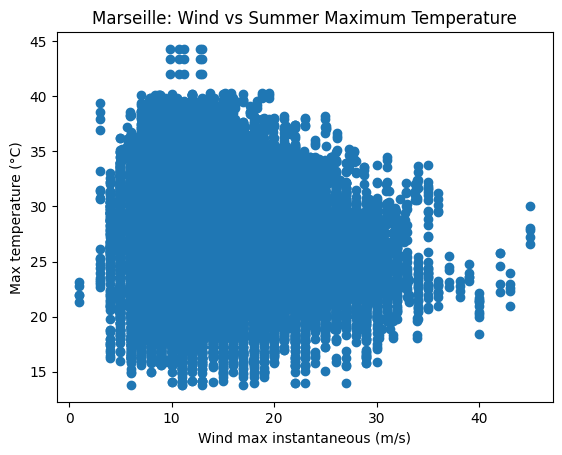

In [4]:

# ======================================================
# 4. Explore data
# ======================================================


# --- Contiue with the Marseille data ---
df = df_marseille.copy()

# Ensure datetime
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month

# Keep summer months (JJA)
df_summer = df[df["month"].isin([6, 7, 8])]

# --- Choose variables ---
temp_col = "TX"                 # or "temp_max_c" (pick one and be consistent)
wind_col = "wind_max_inst_ms"

# --- Scatter plot ---
plt.figure()
plt.scatter(df_summer[wind_col], df_summer[temp_col])
plt.xlabel("Wind max instantaneous (m/s)")
plt.ylabel("Max temperature (°C)")
plt.title("Marseille: Wind vs Summer Maximum Temperature")
plt.show()

# Interpretation:
# Wind speed is not linearly correlated with summer maximum temperature, 
#but it may act as a limiting factor for extreme heat and may become 
#informative when modelling heatwave occurrence or when using non-linear 
#models such as Random Forests, decision trees, or gradient boosting.

# 5. Find heatwaves

In [5]:

# ======================================================
# 5. Find heatwaves
# ======================================================


df = df_marseille.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

TX_P95 = df["TX"].quantile(0.95)
df["hot_day"] = df["TX"] >= TX_P95

# Explicit consecutive-day counter
df["hot_spell_len"] = 0
count = 0

for i, is_hot in enumerate(df["hot_day"]):
    if is_hot:
        count += 1
    else:
        count = 0
    df.loc[i, "hot_spell_len"] = count

# Heatwave tags: date are greater than or equal to (ge) 3 days.
df["heatwave_ge_3days"] = df["hot_spell_len"] >= 3
df["heatwave_gt_3days"] = df["hot_spell_len"] > 3

# 6. Summer analysis: wind vs temperature with heatwaves

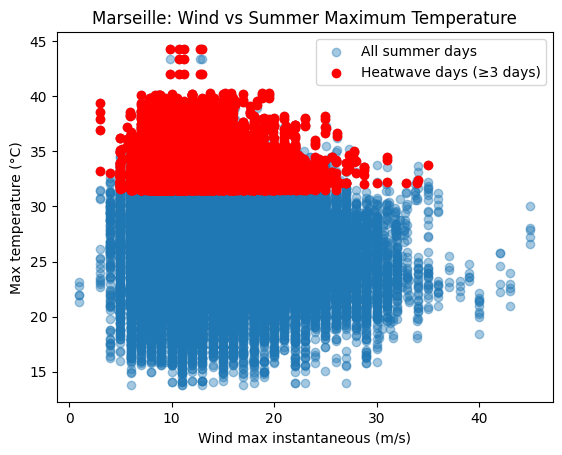

In [6]:
# ======================================================
# 6. Summer analysis: wind vs temperature with heatwaves
# ======================================================



# Recreate summer subset AFTER heatwave tags exist
df["month"] = df["date"].dt.month
df_summer = df[df["month"].isin([6, 7, 8])]

temp_col = "TX"
wind_col = "wind_max_inst_ms"

# All summer days
plt.figure()
plt.scatter(
    df_summer[wind_col],
    df_summer[temp_col],
    alpha=0.4,
    label="All summer days"
)

# Heatwave days (≥ 3 consecutive days)
hw = df_summer[df_summer["heatwave_ge_3days"]]

plt.scatter(
    hw[wind_col],
    hw[temp_col],
    color="red",
    label="Heatwave days (≥3 days)"
)

plt.xlabel("Wind max instantaneous (m/s)")
plt.ylabel("Max temperature (°C)")
plt.title("Marseille: Wind vs Summer Maximum Temperature")
plt.legend()
plt.show()

# 7. ML classification: heatwave occurrence 

In [7]:
#df.columns

#missing too many data in "wind_mean_2m_ms"
features = [
    "wind_mean_10m_ms",
    "wind_max_hourly_ms",
    "wind_max_inst_ms",
    "wind_gust_3s_ms",
    "wind_dir_max_deg",
    "wind_dir_inst_deg"
]

target = "TX"
# Drop missing values
df_ml = df_summer[features + [target]].dropna()

X = df_ml[features]
y = df_ml[target]

print(df_summer[features + [target]].isna().sum())
print(df_summer.shape)
print(df_ml.shape)

df_ml = df_summer[features + [target]].dropna()
print(df_ml.shape)

wind_mean_10m_ms      26760
wind_max_hourly_ms    66855
wind_max_inst_ms      20067
wind_gust_3s_ms       76435
wind_dir_max_deg      66935
wind_dir_inst_deg     30540
TX                     5065
dtype: int64
(165790, 18)
(82389, 7)
(82389, 7)


In [31]:



# Train / test split (NO stratify for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

# Model
# Regression not classifiction for continiiys TX values.
# Will use MAE, R² to eveluate. 
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
results_df = pd.DataFrame([{
    "model": "Gradient Boosting (TX regression)",
    "MAE": mean_absolute_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
}])

display(results_df)


# Feature importance
importances = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)


#print("Feature importance")
display(importances)

# Interpretation:
# The Gradient Boosting regression model shows moderate errors (MAE ≈ 2.8 °C)
# and low explained variance (R² ≈ 0.14), indicating that wind variables alone
# capture only a small fraction of daily maximum temperature (TX) variability.
#
# Among the wind features, wind_mean_10m_ms has the highest relative importance,
# suggesting that near-surface wind intensity is the most informative wind-related
# predictor of TX in this dataset. Wind direction variables are of secondary
# importance, likely reflecting higher variability and regime dependence.
#
# Next steps:
# 1. Reproduce for the other cities. 
#    Optional: try other models.
# 2. Add a persistence baseline (TX at t−1) to quantify the marginal contribution
#    of wind variables beyond simple temperature correlation.
# 2. If time allows: look to incorporate humidity data, which is expected to play a stronger role in
#    modulating extreme temperatures.
# 3. Beyond the scope of this work: look for data availability, extend the analysis to r
#    adiative drivers (e.g. cloud cover and incoming solar radiation) to determine their impact on 
#    the results. 


,model,MAE,R2
0,Gradient Boosting (TX regression),2.788457,0.139148


wind_mean_10m_ms      0.325214
wind_max_inst_ms      0.178960
wind_gust_3s_ms       0.176863
wind_max_hourly_ms    0.168846
wind_dir_max_deg      0.098323
wind_dir_inst_deg     0.051793
dtype: float64